In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('classic')
sns.set()
%matplotlib inline

In [2]:
#################################################################
' Generate Average Rent by County File for Tableau Map (Figure) '
#################################################################

' Read in Average Rent data file '
df_avg_rent = pd.read_csv("./Data/AvgMonthlyRent2008-2018.csv",header=2)

' Rename columns'
df_avg_rent.columns = ['Property Type','Num Bedrooms','Location','2008','2009','2010','2011','2012','2013','2014','2015','2016','2017','2018']

' Cut off bottom of file (which has text) '
df_avg_rent = df_avg_rent.iloc[0:18780,:]


' Create dictionary of dataframes '
dict_df_avg_rent = {}
dict_df_avg_rent['Detached house'] = {}
dict_df_avg_rent['Semi detached house'] = {}
dict_df_avg_rent['Terrace house'] = {}
dict_df_avg_rent['Apartment'] = {}
dict_df_avg_rent['Other flats'] = {}
dict_df_avg_rent['All property types'] = {}

property_types = ['Detached house','Semi detached house','Terrace house','Apartment','Other flats','All property types']
bed_categories = ['One bed','Two bed','Three bed', '1 to 2 bed','1 to 3 bed','Four plus bed','All bedrooms']

propertyTypeIndex = []
for propertyType in property_types:
    propertyTypeIndex.append(df_avg_rent[df_avg_rent['Property Type']==propertyType].index[0])

for bedCategory in bed_categories:
    
    ' Retrieve all index values matching bed category '
    numBedIndexes = df_avg_rent[df_avg_rent['Num Bedrooms']==bedCategory].index
    
    for numBedIndex in numBedIndexes:
        
        ' Determine the property type that numBedIndex belongs to '
        propertyIndex = -1
        
        for i in range(len(propertyTypeIndex)-1):
            if numBedIndex > propertyTypeIndex[i] and numBedIndex < propertyTypeIndex[i+1]:
                propertyIndex = i
                
        if propertyIndex == -1:
            propertyIndex = len(propertyTypeIndex)-1
            
        ' Extract data into dataframe '
        dict_df_avg_rent[property_types[propertyIndex]][bedCategory] = df_avg_rent.iloc[(numBedIndex+1):(numBedIndex+447),2:14]

        
##################################
' Create output file for Tableau '
##################################

' Create new dataframe '
df_avg_rent_for_tableau = pd.DataFrame()

counties = ['Carlow', 'Dublin', 'Wexford', 'Wicklow', 'Louth', 'Kildare', 'Meath', 'Westmeath', 'Kilkenny', 'Laois', 'Offaly', 'Longford', 'Clare', 'Cork', 'Kerry', 'Limerick', 'Tipperary', 'Waterford', 'Galway', 'Leitrim', 'Mayo', 'Roscommon', 'Sligo', 'Cavan', 'Donegal', 'Monaghan']
propertySizes = ['One bed','Two bed','Three bed','Four plus bed','All bedrooms']
property_types = ['Detached house','Semi detached house','Terrace house','Apartment','Other flats','All property types']
bed_categories = ['One bed','Two bed','Three bed','Four plus bed','All bedrooms']
                  
for propertyType in property_types:
    
    for bedCategory in bed_categories:
        
        print propertyType,bedCategory
        
        ' Extract only county data from dictionary '
        df = dict_df_avg_rent[propertyType][bedCategory][ dict_df_avg_rent[propertyType][bedCategory]['Location'].isin(counties) ]
        df.set_index('Location',inplace=True)
        
        ' Convert from wide to long format '
        df_minor = pd.DataFrame()
        for i in range(len(df)):
            df_county_row = df.iloc[i].to_frame()
            county = df_county_row.columns[0]
            df_county_row['County'] = county
            df_county_row.columns = ['Rent','County']
            df_minor = df_minor.append(df_county_row)
        
        
        ' Add property and bedroom columns '
        df_minor['Property Type'] = propertyType
        df_minor['Number of bedrooms'] = bedCategory
        
        ' Append result to main dataframe '
        df_avg_rent_for_tableau = df_avg_rent_for_tableau.append(df_minor)

        
df_avg_rent_for_tableau.reset_index(inplace=True)
df_avg_rent_for_tableau.columns = ['Year','Rent','County','Property Type','Number of Bedrooms']
#df_avg_rent_for_tableau.set_index('Year',inplace=True)
df_avg_rent_for_tableau.to_csv('./Figures/avgCountyRentForTableau.csv')

Detached house One bed
Detached house Two bed
Detached house Three bed
Detached house Four plus bed
Detached house All bedrooms
Semi detached house One bed
Semi detached house Two bed
Semi detached house Three bed
Semi detached house Four plus bed
Semi detached house All bedrooms
Terrace house One bed
Terrace house Two bed
Terrace house Three bed
Terrace house Four plus bed
Terrace house All bedrooms
Apartment One bed
Apartment Two bed
Apartment Three bed
Apartment Four plus bed
Apartment All bedrooms
Other flats One bed
Other flats Two bed
Other flats Three bed
Other flats Four plus bed
Other flats All bedrooms
All property types One bed
All property types Two bed
All property types Three bed
All property types Four plus bed
All property types All bedrooms


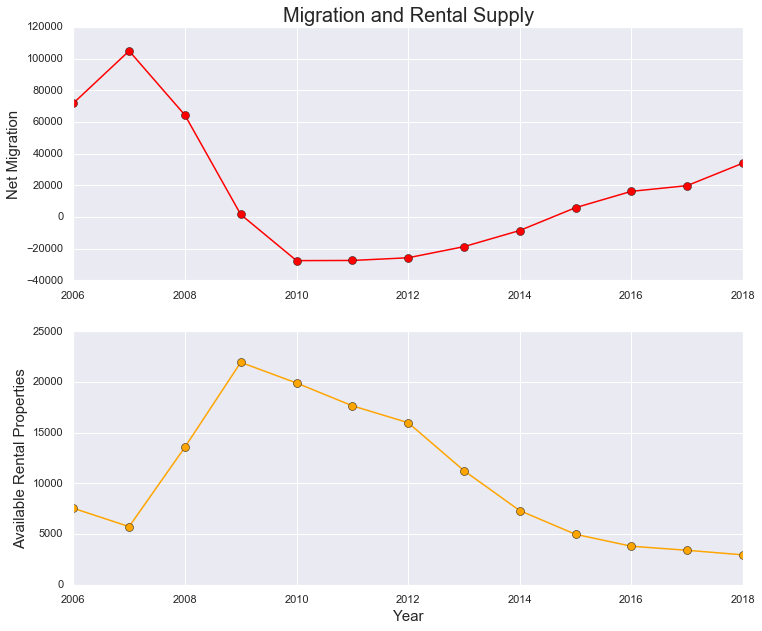

In [3]:
##################################################
' Generate Net Migration vs Rental Supply Figure '
##################################################


' Extract COUNTY data for all property types '

counties = ['Carlow', 'Dublin', 'Wexford', 'Wicklow', 'Louth', 'Kildare', 'Meath', 'Westmeath', 'Kilkenny', 'Laois', 'Offaly', 'Longford', 'Clare', 'Cork', 'Kerry', 'Limerick', 'Tipperary', 'Waterford', 'Galway', 'Leitrim', 'Mayo', 'Roscommon', 'Sligo', 'Cavan', 'Donegal', 'Monaghan']

propertySizes = ['One bed','Two bed','Three bed','Four plus bed','All bedrooms']

dfCountyByNumBeds = {}

for numBeds in propertySizes:
    
    isCounty = dict_df_avg_rent['All property types'][numBeds]['Location'].isin(counties)

    dfCountyByNumBeds[numBeds] = dict_df_avg_rent['All property types'][numBeds][isCounty]
    
    dfCountyByNumBeds[numBeds].set_index('Location',inplace=True)


' Average Rent (for all property sizes) in each county '
df_rent = dfCountyByNumBeds['All bedrooms'].transpose()
df_rent.rename_axis('Year',inplace=True)
df_rent.index = df_rent.index.astype(int);

' Add new column'
df_rent['DublinRentChange']=df_rent['Dublin']-df_rent['Dublin'].shift(1)

' Read in population/migration data file '
df_pop = pd.read_csv("./Data/PopulationAndMigrationEstimates.csv")
df_pop.set_index('Year',inplace=True)

' Read in Daft data '
df_daft = pd.read_csv("./Data/DaftAvailableRentalProperties2006-2019.csv")
df_daft['Year'] = df_daft['Date'].apply(lambda x:x[0:4])

Years = []
numAvailableProperties = []

for year in range(2006,2019):
    df = df_daft[df_daft['Year']==str(year)]
    Years.append(year)
    numAvailableProperties.append(int(df['Number of properties available for rent'].mean()))
    
df_available_properties = pd.DataFrame({'Year':Years,'Available Properties':numAvailableProperties})
df_available_properties.set_index('Year',inplace=True)

' Merge above three dataframes into one master dataframe '
mergedDf = df_pop.merge(df_rent, left_index=True, right_index=True)
df_master = mergedDf.merge(df_available_properties, left_index=True, right_index=True)


' Merge above three dataframes into one master dataframe '
df_pop_available_properties = df_pop.merge(df_available_properties, left_index=True, right_index=True)
df_pop_available_properties

dfplot = df_pop_available_properties
dfplot.index = dfplot.index.astype(int);
dfplot['Net Mig'] = 1000*dfplot['Net migration']

plt.subplot(2,1,1); 
ax = dfplot['Net Mig'].plot(figsize=(12, 10),marker='o',color='red',markersize=8); 
ax.set_title('Migration and Rental Supply',fontsize=20)
ax.set_ylabel('Net Migration',fontsize=15);
ax.set_xlabel('');
ax.ticklabel_format(useOffset=False, style='plain')

plt.subplot(2,1,2); 
ax = dfplot['Available Properties'].plot(figsize=(12, 10),marker='o',color='orange',markersize=8); 
ax.set_ylabel('Available Rental Properties',fontsize=15);
ax.set_xlabel('Year',fontsize=15);
ax.ticklabel_format(useOffset=False, style='plain')

#plt.legend(loc='best');
#plt.legend(bbox_to_anchor=(0.17, 0.75), loc=8, borderaxespad=0);
plt.savefig('./Figures/MigrationVsRentalSupply.png')

In [14]:
#######################
' Miscellaneous Plots '
#######################

<Figure size 432x288 with 0 Axes>

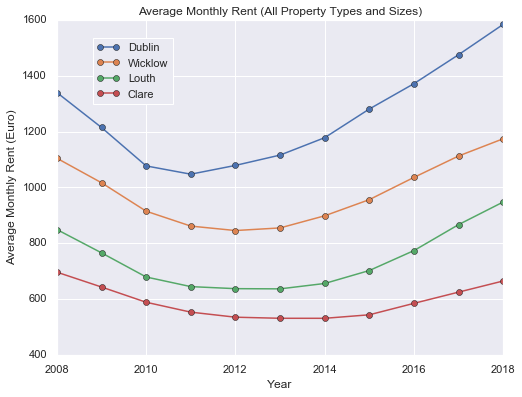

In [4]:
countyList = ['Dublin','Wicklow','Louth','Clare'];
plt.figure(); 
dfplot = dfCountyByNumBeds['All bedrooms'].transpose()[countyList];
dfplot.index = dfplot.index.astype(int);
ax = dfplot.plot(figsize=(8, 6),title='Average Monthly Rent (All Property Types and Sizes)',marker='o'); 
ax.set_xlabel('Year');
ax.set_ylabel('Average Monthly Rent (Euro)');
#plt.legend(loc='best');
ax.ticklabel_format(useOffset=False, style='plain')
plt.legend(bbox_to_anchor=(0.17, 0.75), loc=8, borderaxespad=0);
plt.savefig('./Figures/AvgMonthlyRentTOT.png')

In [5]:
df_minRent = {}

for numBeds in propertySizes:
    
    minRentList = []
    minYearList = []

    for county in counties:
        rentsForCounty = dfCountyByNumBeds[numBeds].loc[county]
        minRent = min(rentsForCounty)
        minYear = rentsForCounty[rentsForCounty==minRent].index[0]
        minRentList.append(minRent)
        minYearList.append(minYear)
    
    df_minRent[numBeds] = pd.DataFrame({'Year':minYearList,'minRent':minRentList})
    df_minRent[numBeds].index = counties
    
df_minRent['All bedrooms'].sort_values('minRent')
df_minRent['All bedrooms'].to_csv('./Figures/minYearForRent.csv')

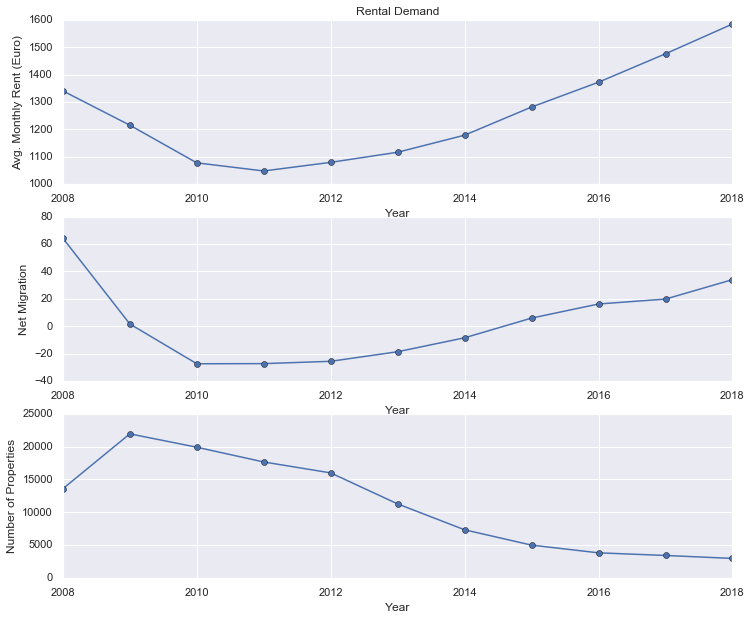

In [6]:
plt.subplot(3,1,1); 
dfplot = df_master
dfplot.index = dfplot.index.astype(int);
ax = dfplot['Dublin'].plot(figsize=(12, 10),title='Rental Demand',marker='o'); 
ax.set_ylabel('Avg. Monthly Rent (Euro)');
ax.ticklabel_format(useOffset=False, style='plain')

plt.subplot(3,1,2); 
ax = dfplot['Net migration'].plot(figsize=(12, 10),marker='o'); 
ax.set_ylabel('Net Migration');
ax.ticklabel_format(useOffset=False, style='plain')

plt.subplot(3,1,3); 
ax = dfplot['Available Properties'].plot(figsize=(12, 10),marker='o'); 
ax.set_ylabel('Number of Properties');
ax.ticklabel_format(useOffset=False, style='plain')

#plt.legend(loc='best');
#plt.legend(bbox_to_anchor=(0.17, 0.75), loc=8, borderaxespad=0);
#plt.savefig('./Figures/AvgMonthlyRentTOT.png')